In [1]:
import numpy as np
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

import io
from urllib.request import urlopen

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_26326/1168612819.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [3]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)
    
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')
    
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()
    
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])


def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()
    
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)
        
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.figure(figsize=(13,5))
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.legend()

In [4]:
t1 = './data/naver_w.mp3'
t2 = './data/oxford_w.mp3'

y_t1, sr = librosa.load(t1)
y_t2, _ = librosa.load(t2)

hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

y_t1 = librosa.effects.preemphasis(y_t1)
y_t2 = librosa.effects.preemphasis(y_t2)

y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)

t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

t1_mfcc_norm = getMFCCNorm(t1_mfcc)
t2_mfcc_norm = getMFCCNorm(t2_mfcc)

t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)

D, wp, wp_s = DTW(t1_mfcc_norm, t2_mfcc_norm)
plotDTW(D, wp_s)
plotAlign(y_t1_trim, y_t2_trim)

x, y, re_wp = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
plotAll(x,y,t1_ae,t2_ae)

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './data/naver_w.mp3'

In [295]:
import sre_parse

def sound_diff(path, ref, target, sr):

    def onsetDetect(signal, sr, hop_length, n_fft):
        onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
        onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
        trim_frames = []
        trim_frames.append(onset_frames_back[0]-1)
        trim_frames.append(onset_frames[-1]+2)
        trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
        return trim_frames, trim_times
        
    def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
        mfccs = mfccs[1:,]
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return comprehensive_mfccs
        
    def amplitude_envelope(signal, n_fft, hop_length):
        return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])

    def getMFCCNorm(mfcc):
        norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
        return norm.T

    def DTW(ref_mfcc, comp_mfcc):
        D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
        wp_s = np.asarray(wp) * hop_length / sr
        return D, wp, wp_s

    def plotDTW(D, wp_s):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)
        librosa.display.specshow(D, x_axis='time', y_axis='time',
                                cmap='gray_r', hop_length=hop_length)
        ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
        plt.rcParams['axes.grid']=False
        plt.colorbar()
        plt.title('Warping Path on Acc. Cost Matrix $D$')
    
    def getDiff(ref_mfcc, comp_mfcc, wp, sr, hop_length, n_fft):
        x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
        x_time = librosa.frames_to_time(x, sr=sr, hop_length=hop_length, n_fft = n_fft)
        re_wp = wp[::-1]
        y = [0] * ref_mfcc.shape[1]
        sig1 = 0
        for a, b in re_wp:
            tmp = sum(np.abs(ref_mfcc[:,a]))
            val = max(0,abs(sum(np.abs(ref_mfcc[:,a])) - sum(np.abs(comp_mfcc[:,b])))/(tmp if int(tmp) !=0 else 1))
            if sig1 == a:
                y[a] = min(y[a],val)
            else:
                y[a] = min(1, val)
                sig1 = a
        return x_time, y, re_wp

    def plotAlign(ref, comp, x, y, ref_ae, comp_ae):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(13, 15))
        
        # Plot x_2
        librosa.display.waveshow(comp, sr=sr, ax=ax2)
        ax2.set(title='comparison waveplot')
        ax2.grid(True, axis='both')

        # Plot x_1
        librosa.display.waveshow(ref, sr=sr, ax=ax1)
        ax1.set(title='reference waveplot')
        ax1.label_outer()
        ax1.grid(True, axis='both')
        n_arrows = 20
        for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
            con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                                axesA=ax1, axesB=ax2,
                                coordsA='data', coordsB='data',
                                color='r', linestyle='--',
                                alpha=0.5)
            ax2.add_artist(con)
        
        ax3.set(title='ref v comparison')
        ax3.grid(True, axis='both')
        ax3.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
        ax3.plot(x,ref_ae, label="ref", color = 'darkblue')
        ax3.plot(x,comp_ae, label="comp", color = 'skyblue')
        ax3.set_xlabel("Time")
        ax3.set_ylim(ymin=0, ymax=1)
        ax3.legend()

    y_ref, sr = librosa.load(path+ref, mono=True, sr=sr)
    y_comp, _ = librosa.load(path+target, mono=True, sr=sr)

    hop_length = int(round(0.01 * sr,0))
    n_fft = int(round(0.025 * sr,0))

    y_ref = librosa.effects.preemphasis(y_ref)
    y_comp = librosa.effects.preemphasis(y_comp)

    y_ref_trim, _ = librosa.effects.trim(y_ref, top_db = 25)
    y_comp_trim, _ = librosa.effects.trim(y_comp, top_db = 25)

    # y_ref_trim = y_ref
    # y_comp_trim = y_comp

    ref_mfcc = getMFCC(y_ref_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
    comp_mfcc = getMFCC(y_comp_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

    ref_mfcc_norm = getMFCCNorm(ref_mfcc)
    comp_mfcc_norm = getMFCCNorm(comp_mfcc)

    # ref_mfcc_norm = ref_mfcc
    # comp_mfcc_norm = comp_mfcc

    if comp_mfcc_norm.shape[1] > ref_mfcc_norm.shape[1]:
        
        c = scipy.signal.correlate(y_comp_trim, y_ref_trim, mode="valid", method="fft")
        peak = np.argmax(c)
        
        zeros = np.zeros(int(round(peak,0)),)
        y_ref_trim = np.concatenate((zeros, y_ref_trim), axis=0)

        zeros = np.zeros((int(y_comp_trim.shape[0]) - int(y_ref_trim.shape[0]),))
        y_ref_trim = np.concatenate((y_ref_trim, zeros), axis=0)

        zeros = np.zeros((int(ref_mfcc_norm.shape[0]), int(round(peak/hop_length,0))))
        ref_mfcc_norm = np.concatenate((zeros, ref_mfcc_norm), axis=1)

        zeros = np.zeros((int(ref_mfcc_norm.shape[0]), int(comp_mfcc_norm.shape[1]) - int(ref_mfcc_norm.shape[1])))
        ref_mfcc_norm = np.concatenate((ref_mfcc_norm, zeros), axis=1)
    
    # if comp_mfcc_norm.shape[1] < ref_mfcc_norm.shape[1]:

    #     c = scipy.signal.correlate(y_ref_trim, y_comp_trim, mode="valid", method="fft")
    #     peak = np.argmax(c)
        
    #     zeros = np.zeros(int(round(peak,0)),)
    #     y_comp_trim = np.concatenate((zeros, y_comp_trim), axis=0)

    #     zeros = np.zeros((int(y_ref_trim.shape[0]) - int(y_comp_trim.shape[0]),))
    #     y_comp_trim = np.concatenate((y_comp_trim, zeros), axis=0)

    #     zeros = np.zeros((int(comp_mfcc_norm.shape[0]), int(round(peak/hop_length,0))))
    #     comp_mfcc_norm = np.concatenate((zeros, comp_mfcc_norm), axis=1)

    #     zeros = np.zeros((int(comp_mfcc_norm.shape[0]), int(ref_mfcc_norm.shape[1]) - int(comp_mfcc_norm.shape[1])))
    #     comp_mfcc_norm = np.concatenate((comp_mfcc_norm, zeros), axis=1)

    D, wp, wp_s = DTW(ref_mfcc_norm, comp_mfcc_norm)
    x, y, re_wp = getDiff(ref_mfcc_norm, comp_mfcc_norm, wp, sr, hop_length, n_fft)
    ref_ae = amplitude_envelope(y_ref_trim, n_fft, hop_length)
    comp_ae = amplitude_envelope(y_comp_trim, n_fft, hop_length)

    plotDTW(D, wp_s)
    plotAlign(y_ref_trim, y_comp_trim, x, y, ref_ae, comp_ae)

    return x, y, re_wp, ref_mfcc_norm, comp_mfcc_norm, y_ref_trim, y_comp_trim, ref_mfcc, comp_mfcc 
    

In [291]:
path = '../english_recordings/test/'
ref = 'english2_stella.mp3'
comp = 'korean2_stella.mp3'
sr = 22050

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


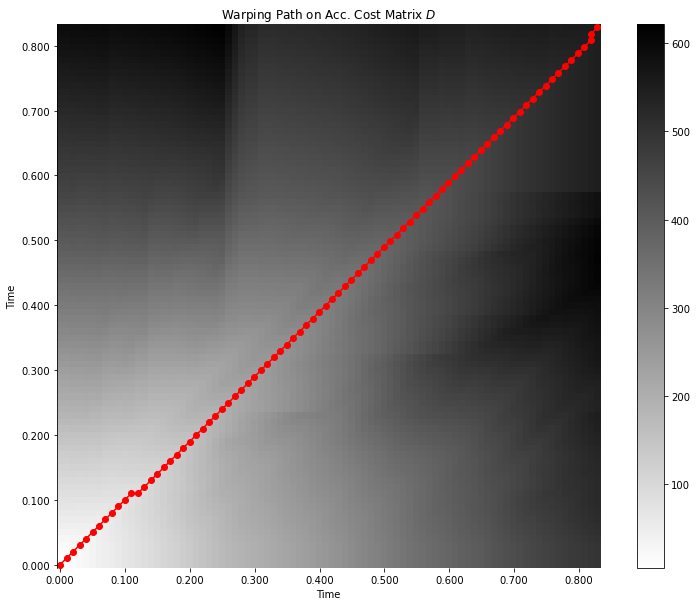

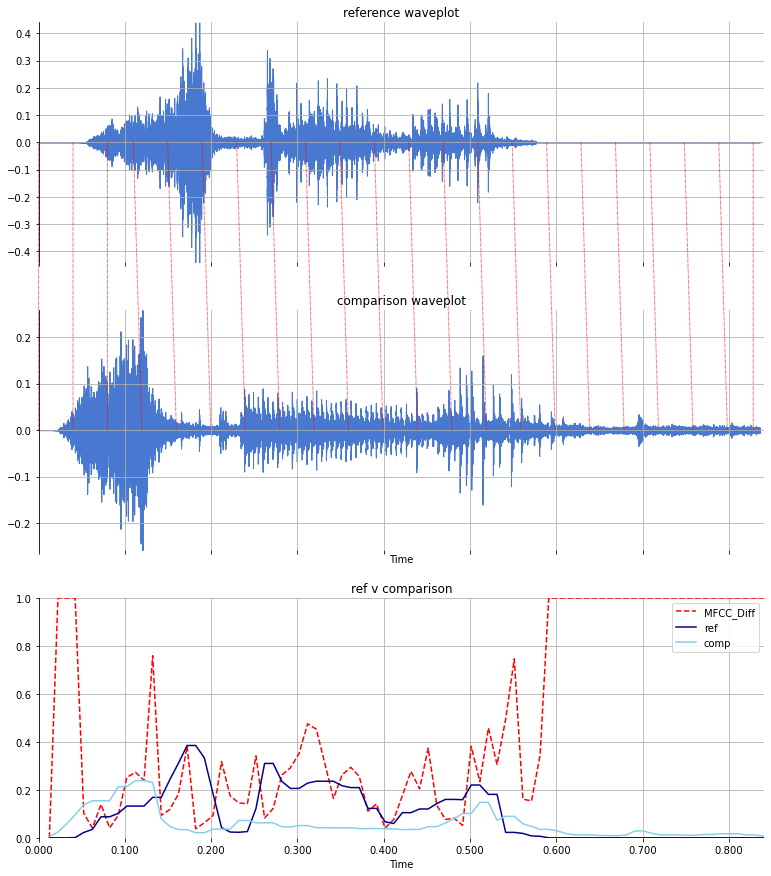

In [296]:
x, y, re_wp, ref_mfcc_norm, comp_mfcc_norm, y_ref_trim, y_comp_trim, ref_mfcc, comp_mfcc = sound_diff(path, ref, comp, sr)

In [238]:
x.shape, ref_mfcc_norm.shape, comp_mfcc_norm.shape, re_wp.shape

((87,), (36, 87), (36, 87), (87, 2))

In [240]:
y[-1]

0.12183866919203391

In [210]:
i = 0
for val in y:
    print(i, ": ", val)
    i += 1

0 :  0
1 :  1
2 :  1
3 :  1
4 :  1
5 :  1
6 :  1
7 :  0.0024223594728454054
8 :  0.02300463287880634
9 :  0.16735253802074151
10 :  0.17851264771209613
11 :  0.18351106388559757
12 :  0.10177827058267593
13 :  0.06989745682433379
14 :  0.06643727837066672
15 :  0.0354006918595183
16 :  0.03232850708462543
17 :  0.05079600050158445
18 :  0.05231177168058538
19 :  0.05728550661546493
20 :  0.058101362377690396
21 :  0.07503155661010635
22 :  0.07638966448854967
23 :  0.013947012747692916
24 :  0.012749900332903531
25 :  0.05675339349707712
26 :  0.05981364485482051
27 :  0.07965100197518983
28 :  0.09707733073915502
29 :  0.07167051409034608
30 :  0.04436975163216976
31 :  0.013074043843777411
32 :  0.047010195826422185
33 :  0.04749771306939801
34 :  0.09006200273241398
35 :  0.002203743432473096
36 :  0.024626450061828578
37 :  0.026870264966791076
38 :  0.00967197482333199
39 :  0.013746770143679293
40 :  0.012640595411197572
41 :  0.008559797622296998
42 :  0.06291085922600312
43 :  

In [223]:
y_ref_trim[-10]

1.3591583e-05

In [224]:
y_comp_trim[-10]

1.3591583e-05

In [241]:
ref_mfcc[:,-1]

array([ 1.1355816 ,  1.1316531 ,  1.1251183 ,  1.1160002 ,  1.1043293 ,
        1.0901433 ,  1.0734878 ,  1.0544236 ,  1.0329981 ,  1.009297  ,
        0.9833914 ,  0.955367  , -2.219934  , -2.1513488 , -2.0410163 ,
       -1.8946095 , -1.7195154 , -1.5243266 , -1.318271  , -1.1106024 ,
       -0.91002184, -0.7241471 , -0.55909675, -0.41919127,  0.45902288,
        0.4223038 ,  0.36322898,  0.28485438,  0.19120811,  0.08705813,
       -0.02236067, -0.13164555, -0.23553157, -0.32918176, -0.40845338,
       -0.47011515], dtype=float32)

In [242]:
comp_mfcc[:,-1]

array([ 1.1355816 ,  1.1316531 ,  1.1251183 ,  1.1160002 ,  1.1043293 ,
        1.0901433 ,  1.0734878 ,  1.0544236 ,  1.0329981 ,  1.009297  ,
        0.9833914 ,  0.955367  , -2.219934  , -2.1513488 , -2.0410163 ,
       -1.8946095 , -1.7195154 , -1.5243266 , -1.318271  , -1.1106024 ,
       -0.91002184, -0.7241471 , -0.55909675, -0.41919127,  0.45902288,
        0.4223038 ,  0.36322898,  0.28485438,  0.19120811,  0.08705813,
       -0.02236067, -0.13164555, -0.23553157, -0.32918176, -0.40845338,
       -0.47011515], dtype=float32)

In [243]:
ref_mfcc_norm[:,-1]

array([-0.69390565, -0.28574976, -1.2489052 , -0.36870262,  0.00718712,
       -0.06367628,  0.17330267,  0.03113927,  0.39869455,  0.60725814,
        0.303411  ,  0.09720075, -0.25839993, -0.4014444 , -0.7043742 ,
       -0.71160644, -0.3530282 , -0.6576672 , -0.36570057, -0.5800199 ,
       -0.18640211, -0.42306888, -0.33062533, -0.20193982,  0.0951744 ,
        0.15081444,  0.2747892 ,  0.18059482,  0.12187544,  0.0357356 ,
       -0.00949443, -0.09142062, -0.16120775, -0.37429416, -0.32485807,
       -0.6672853 ], dtype=float32)

In [244]:
comp_mfcc_norm[:,-1]

array([-0.44662422, -0.4726675 , -1.4233059 , -0.6774394 , -0.07512347,
       -0.2746698 ,  0.0579694 , -0.08879406,  0.25440994,  0.62491715,
       -0.09038619, -0.0368874 , -0.13993448, -0.38267705, -0.6310047 ,
       -0.50093114, -0.30113828, -0.52012736, -0.3136818 , -0.44078842,
       -0.11031488, -0.1972706 , -0.22350134, -0.03149274,  0.13189116,
        0.12552862,  0.32588798,  0.20248963,  0.11973031, -0.03316408,
       -0.0074898 , -0.14887461, -0.06860197, -0.26401788, -0.26992574,
       -0.47242537], dtype=float32)

In [179]:
sum(np.abs(ref_mfcc_norm[:,18]))

28.845318162813783

In [180]:
sum(np.abs(comp_mfcc_norm[:,18]))

35.453338008373976

In [181]:
val = sum(np.abs(ref_mfcc_norm[:,18]))

In [182]:
val

28.845318162813783

In [183]:
abs(sum(np.abs(ref_mfcc_norm[:,18])) - sum(np.abs(comp_mfcc_norm[:,18])))/(val if int(val) !=0 else 1)

0.22908465797680072

In [ ]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import pathlib
import os

cambridge = 'https://dictionary.cambridge.org'
dic = 'https://dictionary.cambridge.org/dictionary/english-korean/'
word = 'station'

r = requests.get(dic+word, headers={'User-Agent':'Mozilla/5.0'})
url = r.content
soup = BeautifulSoup(url, 'html.parser')

camb_sound_raw = soup.find_all('source')[2]
camb_sound_geturl = re.search('"(.+?)"', str(camb_sound_raw)).group(1)
camb_sound_ref_url = cambridge+camb_sound_geturl

file = requests.get(camb_sound_ref_url, headers=headers, allow_redirects=True)
path = os.getcwd()+'/data/'
if os.path.exists(path+word) == True:
    pass
else:
    mp3_path = os.makedirs(path+word)
mp3_path = path+word+'/ref.mp3'
open(mp3_path, 'wb').write(file.content)

SSLError: HTTPSConnectionPool(host='dictionary.cambridge.org', port=443): Max retries exceeded with url: /dictionary/english-korean/station (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))

In [8]:
ref_sound = mp3_path
sound_diff(ref_sound, t2)

NameError: name 'mp3_path' is not defined